# 👀 Multilayer perceptron (MLP)

In this notebook, we'll walk through the steps required to train your own multilayer perceptron on the CIFAR dataset

In [3]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

from torchmetrics import Accuracy
import lightning.pytorch as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, RichProgressBar

import torch.utils.data as data

## 0. Parameters <a name="parameters"></a>

In [7]:
batch_size = 32

NUM_WORKERS = int(os.cpu_count() / 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLASSES = len(classes)

## 1. Prepare the Data <a name="prepare"></a>

In [8]:
transform = transforms.Compose(
    [
        # torchvision.transforms.RandomCrop(32, padding=4),
        # torchvision.transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]

)



In [9]:
# Loading TrainSet
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Splitting Trainset to Train / Val
train_set_size = int(len(trainset) * 0.8)
valid_set_size = len(trainset) - train_set_size

seed = torch.Generator().manual_seed(42)
trainset, validset = torch.utils.data.random_split(trainset, [train_set_size, valid_set_size], generator=seed)

Files already downloaded and verified


In [10]:
# Loading
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified


In [11]:
# Making dataloaders

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=NUM_WORKERS)

valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=NUM_WORKERS)

test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=NUM_WORKERS)

### Visualizing

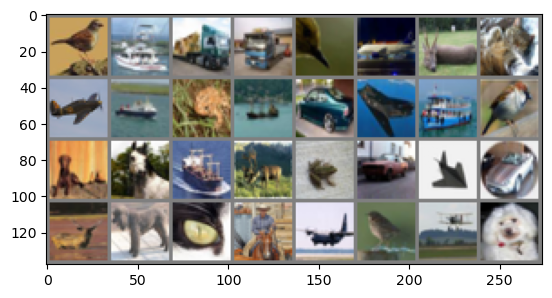

bird  ship  truck truck bird  plane deer  cat   plane ship  frog  ship  car   plane ship  bird  dog   horse ship  deer  frog  car   plane car   deer  dog   cat   horse plane bird  plane dog  


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Build the model <a name="build"></a>

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3 * 32 * 32, 200), nn.ReLU())
        self.l2 = nn.Sequential(nn.Linear(200, 150), nn.ReLU())
        
        self.l3 = nn.Linear(150, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x




In [16]:
class MyLitModel(L.LightningModule):
    def __init__(self, lr = 0.0005):
        super().__init__()

        self.save_hyperparameters()
        # Tip: 
        # The LightningModule allows you to automatically save all the hyperparameters passed to init simply by calling self.save_hyperparameters().
        self.model = Net()
        self.train_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        x = x.view(x.size(0), -1)

        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss)
        acc = self.train_accuracy(logits, y)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("val_loss", loss)
        acc = self.val_accuracy(logits, y)
        self.log("val_accuracy", acc)


    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("val_loss", loss)
        acc = self.val_accuracy(logits, y)
        self.log("val_accuracy", acc)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

## 3. Train the model <a name="train"></a>

In [36]:
model = MyLitModel()

# You can use the checkpoint
# checkpoint = "./log/lightning_logs/version_1/checkpoints/epoch=0-step=1250.ckpt"
# model = MyLitModel.load_from_checkpoint(checkpoint)

trainer = L.Trainer(
    max_epochs=1,
    default_root_dir="./log",
)

trainer.fit(model, train_dataloader, valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | Net                | 646 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | criterion      | CrossEntropyLoss   | 0     
------------------------------------------------------
646 K     Trainable params
0         Non-trainable params
646 K     Total params
2.585     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## 4. Evaluation <a name="evaluate"></a>

In [ ]:
checkpoint = "./log/lightning_logs/version_2/checkpoints/epoch=0-step=1250.ckpt"
model = MyLitModel.load_from_checkpoint(checkpoint)


trainer.test(model, dataloaders=test_dataloader)